In [39]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [40]:
train = pd.read_csv('data/train.csv',parse_dates='datetime',index_col='datetime')
test = pd.read_csv('data/test.csv',parse_dates='datetime',index_col='datetime')
test[:10]


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012


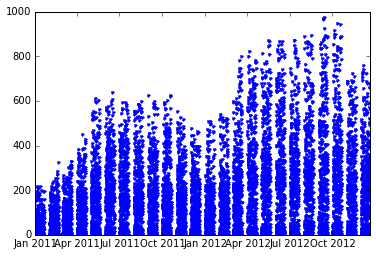

In [5]:
plot(train.index,train['count'],'.')

In [43]:
train['hour'] = train.index.hour
train['month'] = train.index.month
train['year'] = train.index.year - 2011
train['day_of_week'] = train.index.weekday
train[:3]
test['hour'] = test.index.hour
test['month'] = test.index.month
test['year'] = test.index.year - 2011
test['day_of_week'] = test.index.weekday

In [7]:
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation

In [20]:
def error(predictions,actual):
#     print [int(p) for p in predictions[:7]]
#     print [int(p) for p in np.array(actual)[:7]]
    err = 0
    for i, pred in enumerate(predictions):
        err += (np.log1p(pred)-np.log1p(actual[i]))**2
    J = (err/len(predictions))**.5
    return J

In [25]:
features = ['season','holiday','workingday','weather','humidity','temp','atemp','windspeed','hour','month','year', 'day_of_week']
features = ['season','holiday','workingday','weather','humidity','temp','windspeed','hour','month','year', 'day_of_week']
# features = ['casual','registered']
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
# train[features], train['count'], test_size=0.4)
kf = cross_validation.KFold(len(train),5,shuffle=True)

In [36]:
dp = []
for oob in [True] * 5 + [False]*5:
    e_sum = 0
    for tr, te in kf:
        rf = RandomForestRegressor(n_estimators=100, n_jobs=2, min_samples_split=4, oob_score=oob)
        rf.fit(train[features].iloc[tr],train['count'].iloc[tr])
        predictions = rf.predict(train[features].iloc[te])
        e_sum += error(predictions,train['count'].iloc[te])
        print e_sum
    dp.append(e_sum)
    print dp



0.332277401553
0.650251595392
0.985550872831
1.31598778999
1.63533433076
[1.6353343307606294]
0.32899673505
0.646203638406
0.979615343955
1.31212656513
1.63328653322
[1.6353343307606294, 1.6332865332178765]
0.330014265579
0.646941397379
0.980701043546
1.31108237846
1.63227382957
[1.6353343307606294, 1.6332865332178765, 1.632273829566645]
0.330333306691
0.648804790711
0.980415542643
1.31235445726
1.63135815342
[1.6353343307606294, 1.6332865332178765, 1.632273829566645, 1.6313581534156609]
0.33182477526
0.648123651094
0.98201429613
1.31406451819
1.63549928161
[1.6353343307606294, 1.6332865332178765, 1.632273829566645, 1.6313581534156609, 1.6354992816127212]
0.331772074507
0.647603351789
0.98113944519
1.31215277615
1.63239622867
[1.6353343307606294, 1.6332865332178765, 1.632273829566645, 1.6313581534156609, 1.6354992816127212, 1.6323962286708995]
0.333681575393
0.650428590865
0.982571201861
1.312758427
1.63531627334
[1.6353343307606294, 1.6332865332178765, 1.632273829566645, 1.63135815341

**Performance increases dramatically initially by increasing n_estimators**

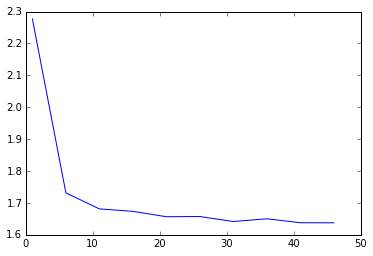

In [28]:
plot(range(1,50,5),dp)

**Increasing n_estimators past ~100 almost negligibly increases performance.**

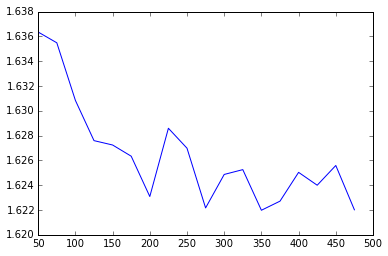

In [30]:
plot(range(50,500,25),dp)

**Changing min_split_samples seems to dip at 4; if anything, increasing hurt**

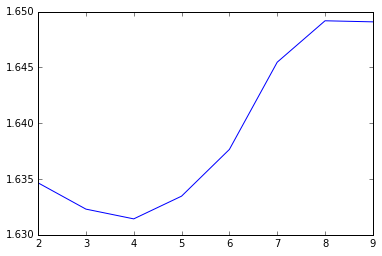

In [34]:
plot(range(2,10),dp)

**oob_score had no effect**

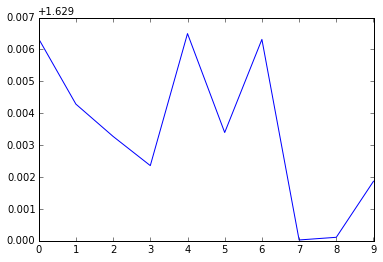

In [37]:
plot(range(10),dp)

In [52]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=2, min_samples_split=4)
rf.fit(train[features],train['count'])
df_submit = pd.DataFrame(data=[int(x) for x in rf.predict(test[features])],index=test.index,columns=['count'])
pd.DataFrame.to_csv(df_submit ,'prediction.csv')
# 0.46856 from Kaggle

In [22]:
for tr, te in kf:
    clf = svm.SVR(kernel='rbf')
    clf.fit(train[features].iloc[tr],train['count'].iloc[tr])
    predictions = clf.predict(train[features].iloc[te])
    print error(predictions,train['count'].iloc[te])

[ 142.02862158  142.91542803  143.97209227  144.7878443   144.26509495
  143.4378417   144.10889169  145.0246254   145.50419024  145.47687256]
[32 13  3 36 94 37 34 20 75 74]
1.4793377807
[ 140.80651637  140.75583596  139.70261293  143.59637108  142.55257523
  142.9587204   142.7577715   142.488591    143.67780589  142.69326682]
[40  1  1 14 84 67 35 36 17  6]
1.4558986716
[ 143.00993655  143.99936072  144.07251103  144.32862687  144.33197098
  144.62186925  144.58471495  145.53931263  144.82476238  144.6604918 ]
[ 16 106  93  28   1   8  70  93  76  65]
1.445432848
[ 142.45077697  142.44767134  142.72011898  142.14765741  142.97625346
  141.36407189  141.47134301  142.6647142   140.1651442   142.72710585]
[  8  56  39  17  30  31   8   5  61 157]
1.44859594118
[ 142.37635905  142.46866142  143.32624587  141.95269281  140.68810456
  142.62893767  142.87325082  143.32042959  140.50221194  142.1659437 ]
[  2 110   9   3  64  76 110  20   1  63]
1.4473907477
